## env: `cmip6`

In [1]:
import os
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#import proplot as pplt
import seaborn as sns
import rioxarray as rio
import matplotlib.patches as mpatches

In [2]:
# Data
ds = xr.open_dataset('North_India_t2m_tp_1950_2021_ERA5L_Monthly.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 131, time: 869)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 83.7 83.8 83.9 84.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 27.3 27.2 27.1 27.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-05-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-16 14:08:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
# Shapefiles
footprint = gpd.read_file('/home/arindan/Documents/Mandal_files/Ladakh_Geodetic Work/Climate_analysis/him_region/aoi_geodetic_paper.shp')
footprint = footprint.to_crs(epsg=4326) # convert to WGS84 (epsg:32643)

# WL and EL regions
wl = gpd.read_file('/home/arindan/Documents/Mandal_files/Ladakh_Geodetic Work/Ladakh_orographic_regions/Zanskar_Nun_only.shp')
wl = wl.to_crs(epsg=4326)
el = gpd.read_file('/home/arindan/Documents/Mandal_files/Ladakh_Geodetic Work/Ladakh_orographic_regions/Ladakh_only.shp')
el = el.to_crs(epsg=4326)

him_regions = gpd.read_file('/home/arindan/Documents/Mandal_files/Ladakh_Geodetic Work/Climate_analysis/him_region/him_regions.shp')

In [6]:
# Change t2m from K to C
ds['t2m'] -= 273.15
ds['t2m'].attrs['units'] = 'C'

In [7]:
# Change tp from m to mm
ds['tp'] *= 1000 * 30.4
ds['tp'].attrs['units'] = 'mm'

In [8]:
# Make annual timeseries of t2m
t2m_annual_timeseries = ds.t2m.groupby('time.year').mean().compute()

In [9]:
# Make annual timeseries of tp
tp_annual_timeseries = ds.tp.groupby('time.year').sum().compute()

#### Extract Leh, Srinagar and Shimla data for validation

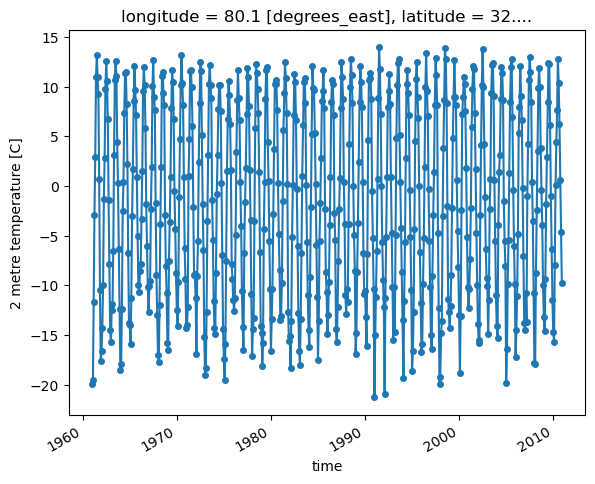

In [10]:
era5l_leh = ds.t2m.sel(longitude=77.7, latitude=34.2, method='nearest')
era5l_leh = era5l_leh.sel(time=slice('1961-01-01', '2010-12-01'))
era5l_leh_df = era5l_leh.to_dataframe()

era5l_sri = ds.t2m.sel(longitude=74.833, latitude=34.083, method='nearest')
era5l_sri = era5l_sri.sel(time=slice('1961-01-01', '2010-12-01'))
era5l_sri_df = era5l_sri.to_dataframe()

era5l_sim = ds.t2m.sel(longitude=77.167, latitude=31.1, method='nearest')
era5l_sim = era5l_sim.sel(time=slice('1961-01-01', '2010-12-01'))
era5l_sim_df = era5l_sim.to_dataframe()

era5l_shi = ds.t2m.sel(longitude=80.083, latitude=32.5, method='nearest')
era5l_shi = era5l_shi.sel(time=slice('1961-01-01', '2010-12-01'))
era5l_shi_df = era5l_shi.to_dataframe()

# Quick plot
era5l_shi.plot(marker='o', size=5, markersize=4)
plt.show()

## Compare ERA5-Land and GHCN-M data

## TAVG

In [11]:
import scipy.stats  as stats
from sklearn.metrics import mean_squared_error

In [12]:
# Import GHCN-M data
df_leh = pd.read_csv('ghcnm_monthly_leh.csv')
df_sri = pd.read_csv('ghcnm_monthly_sri.csv')
df_sim = pd.read_csv('ghcnm_monthly_sim.csv')
df_shi = pd.read_csv('ghcnm_monthly_shi.csv')

In [13]:
print(df_shi.tavg.count())
print(era5l_shi_df.t2m.count())

600
600


In [15]:
# Correlation, p-value and RMSE
corr = stats.pearsonr(df_leh.tavg, era5l_leh_df.t2m)
print(corr)

R_sq = corr[0]**2
print(R_sq)

# If you want the root mean squared error
rmse = mean_squared_error(df_leh.tavg, era5l_leh_df.t2m, squared = False)
print(rmse)

PearsonRResult(statistic=0.9650525369887777, pvalue=0.0)
0.9313263991484761
14.984268924963942


* Leh r2 = 0.93, p = 0, rmse = 14.9
* Srinagar r2 = 0.97, p = 0, rmse = 2.7
* Shimla r2 = 0.97, p = 0, rmse = 2.3
* Shiquanhe r2=0.95, p=0, rmse=3.88

type: index type not supported

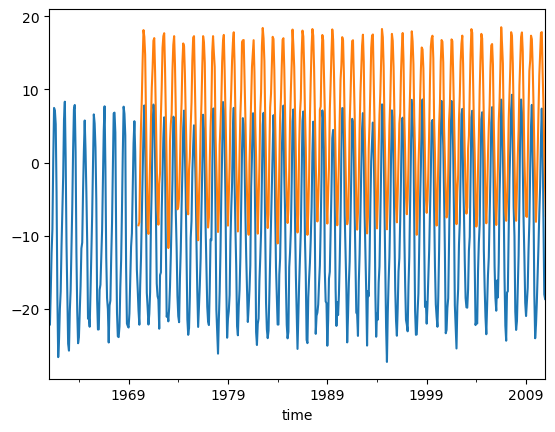

In [33]:
era5l_leh_df.t2m.plot(), df_leh.tavg.plot()

## PRCP

In [16]:
# Import GHCN-M data
pr_leh = pd.read_csv('ghcn4_prcp/INMLP042034.csv')
pr_sri = pd.read_csv('ghcn4_prcp/IN008010200.csv')
pr_sim = pd.read_csv('ghcn4_prcp/IN007101600.csv')
pr_shi = pd.read_csv('ghcn4_prcp/CHM00055228.csv')

In [17]:
# LEH data processing
# Convert to Date
pr_leh['year and month'] = pd.to_datetime(pr_leh['year and month'], format='%Y%m')
#pr_leh['YearMonth'] = pr_leh['year and month'].apply(lambda x: x.strftime('%Y-%m'))

# Rename column
pr_leh.rename(columns={'year and month': 'YearMonth', 'Precipitation value (tenths of a millimeter)': 'PRCP'}, inplace=True)

# Convert PRCP (tenths of a millimeter) to mm/month
# https://cloud.google.com/blog/products/gcp/global-historical-daily-weather-data-now-available-in-bigquery
pr_leh.PRCP = pr_leh.PRCP/10

pr_leh = pr_leh.set_index(['YearMonth'])

pr_leh['Month'] = pr_leh.index.month
pr_leh['Year'] = pr_leh.index.year


# LEH ERA5-Land PRCP Extraction
era5l_leh_pr = ds.tp.sel(longitude=77.7, latitude=34.2, method='nearest')
era5l_leh_pr = era5l_leh_pr.sel(time=slice('1950-01-01', '1969-08-31'))
era5l_leh_pr_df = era5l_leh_pr.to_dataframe()

# Make one df
pr_leh['ERA5L_tp'] = era5l_leh_pr_df.tp
pr_leh.dropna(inplace=True)

In [18]:
# SRINAGAR data processing
# Convert to Date
pr_sri['year and month'] = pd.to_datetime(pr_sri['year and month'], format='%Y%m')
#pr_leh['YearMonth'] = pr_leh['year and month'].apply(lambda x: x.strftime('%Y-%m'))

# Rename column
pr_sri.rename(columns={'year and month': 'YearMonth', 'Precipitation value (tenths of a millimeter)': 'PRCP'}, inplace=True)

# Convert PRCP (tenths of a millimeter) to mm/month
# https://cloud.google.com/blog/products/gcp/global-historical-daily-weather-data-now-available-in-bigquery
pr_sri.PRCP = pr_sri.PRCP/10

pr_sri = pr_sri.set_index(['YearMonth'])

pr_sri['Month'] = pr_sri.index.month
pr_sri['Year'] = pr_sri.index.year


# Srinagar ERA5-Land PRCP Extraction
era5l_sri_pr = ds.tp.sel(longitude=74.833, latitude=34.083, method='nearest')
era5l_sri_pr = era5l_sri_pr.sel(time=slice('1950-01-01', '2021-12-31'))
era5l_sri_pr_df = era5l_sri_pr.to_dataframe()

# Make one df
pr_sri['ERA5L_tp'] = era5l_sri_pr_df.tp
pr_sri.dropna(inplace=True)

In [19]:
# SHIMLA data processing
# Convert to Date
pr_sim['year and month'] = pd.to_datetime(pr_sim['year and month'], format='%Y%m')
#pr_leh['YearMonth'] = pr_leh['year and month'].apply(lambda x: x.strftime('%Y-%m'))

# Rename column
pr_sim.rename(columns={'year and month': 'YearMonth', 'Precipitation value (tenths of a millimeter)': 'PRCP'}, inplace=True)

# Convert PRCP (tenths of a millimeter) to mm/month
# https://cloud.google.com/blog/products/gcp/global-historical-daily-weather-data-now-available-in-bigquery
pr_sim.PRCP = pr_sim.PRCP/10

pr_sim = pr_sim.set_index(['YearMonth'])

pr_sim['Month'] = pr_sim.index.month

# SHIMLA ERA5-Land PRCP Extraction
era5l_sim_pr = ds.tp.sel(longitude=77.167, latitude=31.1, method='nearest')
era5l_sim_pr = era5l_sim_pr.sel(time=slice('1950-01-01', '1987-12-31'))
era5l_sim_pr_df = era5l_sim_pr.to_dataframe()

# Make one df
pr_sim['ERA5L_tp'] = era5l_sim_pr_df.tp
pr_sim.dropna(inplace=True)

In [20]:
# SHIQUANE data processing
# Convert to Date
pr_shi['year and month'] = pd.to_datetime(pr_shi['year and month'], format='%Y%m')
#pr_leh['YearMonth'] = pr_leh['year and month'].apply(lambda x: x.strftime('%Y-%m'))

# Rename column
pr_shi.rename(columns={'year and month': 'YearMonth', 'Precipitation value (tenths of a millimeter)': 'PRCP'}, inplace=True)

# Convert PRCP (tenths of a millimeter) to mm/month
# https://cloud.google.com/blog/products/gcp/global-historical-daily-weather-data-now-available-in-bigquery
pr_shi.PRCP = pr_shi.PRCP/10

pr_shi = pr_shi.set_index(['YearMonth'])

pr_shi['Month'] = pr_shi.index.month

# SHIMLA ERA5-Land PRCP Extraction
era5l_shi_pr = ds.tp.sel(longitude=80.083, latitude=32.5, method='nearest')
era5l_shi_pr = era5l_shi_pr.sel(time=slice('1961-01-01', '1987-12-31'))
era5l_shi_pr_df = era5l_shi_pr.to_dataframe()

# Make one df
pr_shi['ERA5L_tp'] = era5l_shi_pr_df.tp
pr_shi.dropna(inplace=True)

## Correlation/RMSE

In [21]:
# Correlation, p-value and RMSE
corr = stats.pearsonr(pr_shi.PRCP, pr_shi.ERA5L_tp)
print(corr)

R_sq = corr[0]**2
print(R_sq)

# If you want the root mean squared error
rmse = mean_squared_error(pr_shi.PRCP, pr_shi.ERA5L_tp, squared = False)
np.round(rmse, 1)

PearsonRResult(statistic=0.8191438582287067, pvalue=1.0067213643797225e-79)
0.6709966604738116


17.2

* Leh r2 = 0.32, p = 0.00, rmse = 27.9
* Srinagar r2 = 0.44, p = 0, rmse = 96.3
* Shimla r2 = 0.65, p = 0, rmse = 96.7
* Shiquanhe r2=0.67, p= 0, rmse=17.2

## Figure

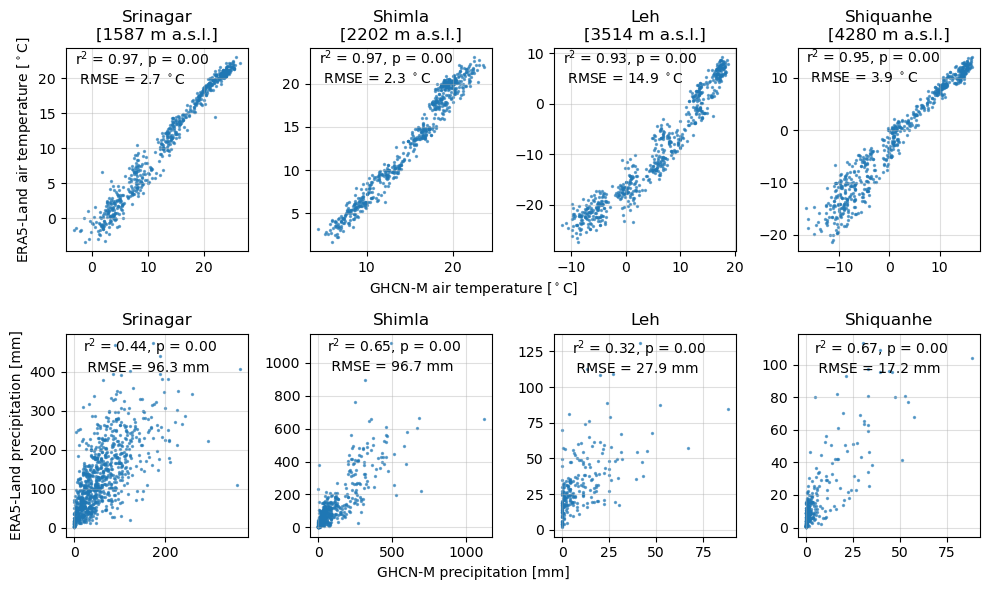

In [24]:
# Figure
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()

axs[0].scatter(df_sri.tavg, era5l_sri_df.t2m, s=2, alpha=0.6)
axs[1].scatter(df_sim.tavg, era5l_sim_df.t2m, s=2, alpha=0.6)
axs[2].scatter(df_leh.tavg, era5l_leh_df.t2m, s=2, alpha=0.6)
axs[3].scatter(df_shi.tavg, era5l_shi_df.t2m, s=2, alpha=0.6)

axs[4].scatter(pr_sri.PRCP, pr_sri.ERA5L_tp, s=2, alpha=0.6)
axs[5].scatter(pr_sim.PRCP, pr_sim.ERA5L_tp, s=2, alpha=0.6)
axs[6].scatter(pr_leh.PRCP, pr_leh.ERA5L_tp, s=2, alpha=0.6)
axs[7].scatter(pr_shi.PRCP, pr_shi.ERA5L_tp, s=2, alpha=0.6)

axs[0].grid(alpha=0.4)
axs[1].grid(alpha=0.4)
axs[2].grid(alpha=0.4)
axs[3].grid(alpha=0.4)
axs[4].grid(alpha=0.4)
axs[5].grid(alpha=0.4)
axs[6].grid(alpha=0.4)
axs[7].grid(alpha=0.4)

axs[1].set_xlabel('GHCN-M air temperature [$^\circ$C]', x=0.9)
axs[5].set_xlabel('GHCN-M precipitation [mm]', x=0.9)
axs[0].set_ylabel('ERA5-Land air temperature [$^\circ$C]')
axs[4].set_ylabel('ERA5-Land precipitation [mm]')

axs[0].set_title('Srinagar\n[1587 m a.s.l.]')
axs[1].set_title('Shimla\n[2202 m a.s.l.]')
axs[2].set_title('Leh\n[3514 m a.s.l.]')
axs[3].set_title('Shiquanhe\n[4280 m a.s.l.]')

axs[4].set_title('Srinagar')
axs[5].set_title('Shimla')
axs[6].set_title('Leh')
axs[7].set_title('Shiquanhe')

axs[0].text(-3, 19, 'r$^2$ = 0.97, p = 0.00 \n RMSE = 2.7 $^\circ$C')
axs[1].text(4.5, 20, 'r$^2$ = 0.97, p = 0.00 \n RMSE = 2.3 $^\circ$C')
axs[2].text(-11.5, 4, 'r$^2$ = 0.93, p = 0.00 \n RMSE = 14.9 $^\circ$C')
axs[3].text(-16.5, 9, 'r$^2$ = 0.95, p = 0.00 \n RMSE = 3.9 $^\circ$C')

axs[4].text(20, 400, 'r$^2$ = 0.44, p = 0.00 \n RMSE = 96.3 mm')
axs[5].text(60, 950, 'r$^2$ = 0.65, p = 0.00 \n RMSE = 96.7 mm')
axs[6].text(5, 110, 'r$^2$ = 0.32, p = 0.00 \n RMSE = 27.9 mm')
axs[7].text(4, 95, 'r$^2$ = 0.67, p = 0.00 \n RMSE = 17.2 mm')

plt.tight_layout()
plt.savefig('era5_land_ghcn_m.jpeg', bbox_inches='tight', dpi=300)
plt.show()

# Trend Analysis

In [24]:
from xarrayutils.utils import linear_trend

# Trend
t2m_trend = linear_trend(t2m_annual_timeseries, 'year')
t2m_trend

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 131)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 83.7 83.8 83.9 84.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 27.3 27.2 27.1 27.0
Data variables:
    slope      (latitude, longitude) float64 0.007961 0.006464 ... 0.001846
    intercept  (latitude, longitude) float64 2.616 2.388 0.842 ... 24.57 24.58
    r_value    (latitude, longitude) float64 0.226 0.1901 ... 0.06138 0.07809
    p_value    (latitude, longitude) float64 0.0545 0.1073 ... 0.606 0.5114
    std_err    (latitude, longitude) float64 0.004072 0.003963 ... 0.002797

In [25]:
# Trend
tp_trend = linear_trend(tp_annual_timeseries, 'year')
tp_trend

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 131)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 83.7 83.8 83.9 84.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 27.3 27.2 27.1 27.0
Data variables:
    slope      (latitude, longitude) float64 3.217 3.052 2.966 ... -6.844 -6.721
    intercept  (latitude, longitude) float64 1.548e+03 1.514e+03 ... 1.837e+03
    r_value    (latitude, longitude) float64 0.2486 0.2476 ... -0.3812 -0.3696
    p_value    (latitude, longitude) float64 0.03392 0.03466 ... 0.001291
    std_err    (latitude, longitude) float64 1.488 1.417 1.363 ... 1.97 2.005

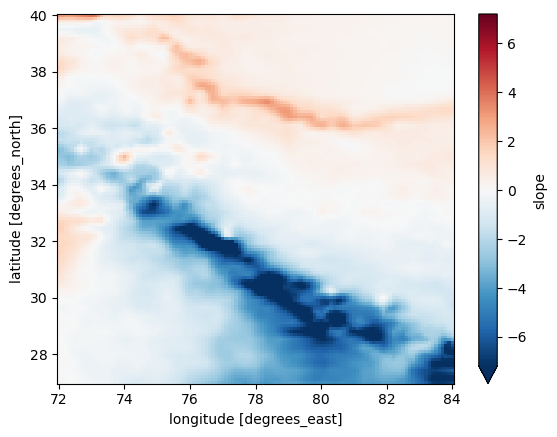

In [26]:
# Test plot
tp_trend.slope.plot(robust=True)

In [27]:
# Make trends at decadal rate
# https://nbviewer.jupyter.org/gist/fmaussion/52076a05f228a610024a84910d91b405
# Run only ONCE
t2m_trend['slope'] = (('latitude', 'longitude'), t2m_trend['slope'].data * 10)
tp_trend['slope'] = (('latitude', 'longitude'), tp_trend['slope'].data * 10)

In [28]:
tp_trend.slope.mean()

<xarray.DataArray 'slope' ()>
array(-10.42534604)

## Anomaly Plots
### Only for the AOI (the black box)

In [30]:
# We compute the anomaly to the first two decade in the dataset as reference
# t2m_annual_timeseries['t2m_ano'] = t2m_annual_timeseries - t2m_annual_timeseries.sel(year=slice('1950', '1970')).mean(dim='year')
# tp_annual_timeseries['tp_ano'] = tp_annual_timeseries - tp_annual_timeseries.sel(year=slice('1950', '1970')).mean(dim='year')

t2m_annual_timeseries['t2m_ano'] = t2m_annual_timeseries - t2m_annual_timeseries.sel(year=slice('1980', '1999')).mean(dim='year')
tp_annual_timeseries['tp_ano'] = tp_annual_timeseries - tp_annual_timeseries.sel(year=slice('1980', '1999')).mean(dim='year')

In [31]:
# Before clipping we need to fit to the same CRS
t2m_annual_timeseries.rio.write_crs(footprint.crs, inplace=True);
tp_annual_timeseries.rio.write_crs(footprint.crs, inplace=True);

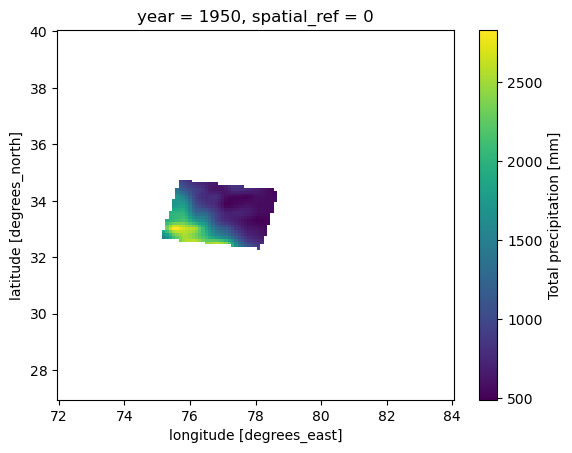

In [32]:
# Crop
t2m_aoi_masked = t2m_annual_timeseries.rio.clip(footprint.geometry, crs=footprint.crs, drop=False)
tp_aoi_masked = tp_annual_timeseries.rio.clip(footprint.geometry, crs=footprint.crs, drop=False)
tp_aoi_masked[0].plot()

In [33]:
# Before clipping we need to fit to the same CRS
t2m_annual_timeseries.rio.write_crs(wl.crs, inplace=True);
tp_annual_timeseries.rio.write_crs(wl.crs, inplace=True);

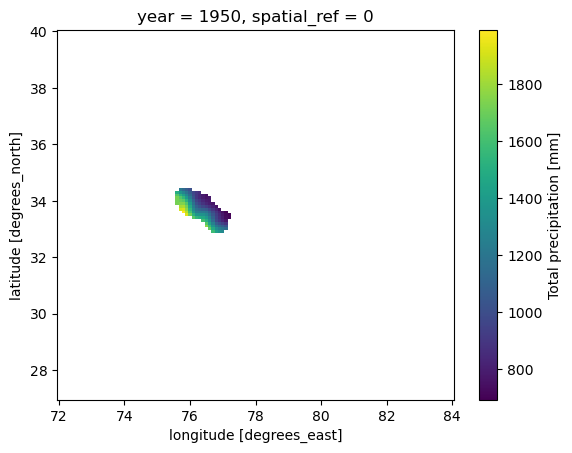

In [34]:
# Crop to WL
t2m_wl_masked = t2m_annual_timeseries.rio.clip(wl.geometry, crs=wl.crs, drop=False)
tp_wl_masked = tp_annual_timeseries.rio.clip(wl.geometry, crs=wl.crs, drop=False)
tp_wl_masked[0].plot()

In [35]:
# Before clipping we need to fit to the same CRS
t2m_annual_timeseries.rio.write_crs(el.crs, inplace=True);
tp_annual_timeseries.rio.write_crs(el.crs, inplace=True);

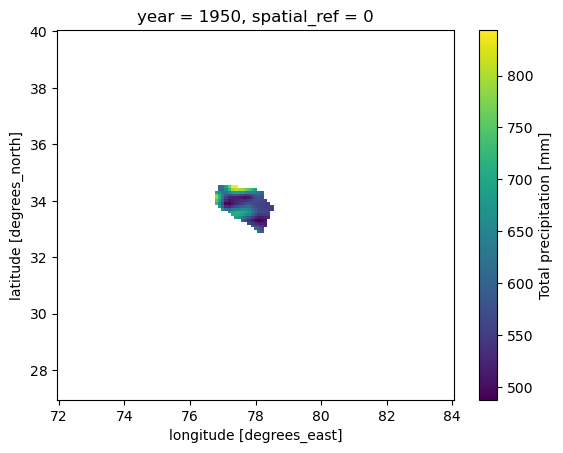

In [36]:
# Crop to WL
t2m_el_masked = t2m_annual_timeseries.rio.clip(el.geometry, crs=el.crs, drop=False)
tp_el_masked = tp_annual_timeseries.rio.clip(el.geometry, crs=el.crs, drop=False)
tp_el_masked[0].plot()

In [37]:
t2m_el_masked.mean()

<xarray.DataArray 't2m' ()>
array(-9.156242, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [38]:
t2m_wl_masked.mean()

<xarray.DataArray 't2m' ()>
array(-8.940459, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [39]:
# Anomaly for the AOI (only; for better representation)
t2m_ano_aoi = t2m_aoi_masked.t2m_ano.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
t2m_ano_00_20_aoi = t2m_aoi_masked.t2m_ano.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

tp_ano = tp_aoi_masked.tp_ano.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
tp_ano_00_20 = tp_aoi_masked.tp_ano.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

# WL
t2m_ano_wl = t2m_wl_masked.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
t2m_ano_00_20_wl = t2m_wl_masked.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

tp_ano_wl = tp_wl_masked.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
tp_ano_00_20_wl = tp_wl_masked.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

# EL
t2m_ano_el = t2m_el_masked.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
t2m_ano_00_20_el = t2m_el_masked.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

tp_ano_el = tp_el_masked.mean(dim=['longitude','latitude']).sel(year=slice('1950', '2020'))
tp_ano_00_20_el = tp_el_masked.mean(dim=['longitude','latitude']).sel(year=slice('2000', '2020'))

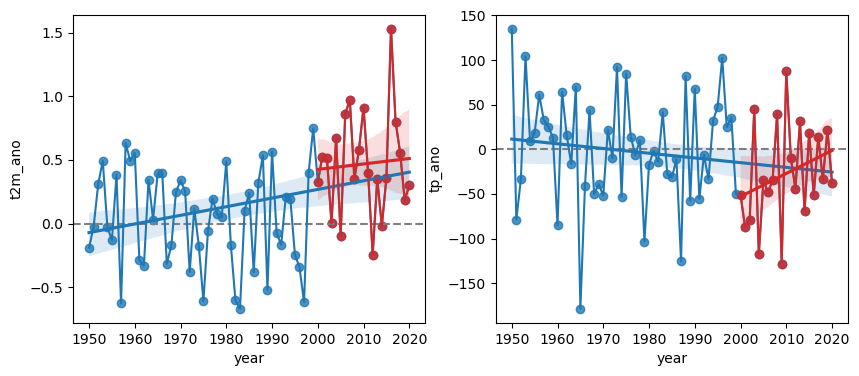

In [40]:
# To highlight the study period 2000-2020
f, ax = plt.subplots(1,2, figsize=(10,4))
ax=ax.flatten()

ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].plot(t2m_ano_aoi.year, t2m_ano_aoi, color='C0', label='Glaciers')
sns.regplot(x=t2m_ano_aoi.year, y=t2m_ano_aoi, color='C0', ax=ax[0], truncate=True)
ax[0].plot(t2m_ano_00_20_aoi.year, t2m_ano_00_20_aoi, color='C3', label='Glaciers')
sns.regplot(x=t2m_ano_00_20_aoi.year, y=t2m_ano_00_20_aoi, color='C3', ax=ax[0], truncate=True)

ax[1].axhline(y = 0, color = 'grey', linestyle = '--')
ax[1].plot(tp_ano.year, tp_ano, color='C0', label='Glaciers')
sns.regplot(x=tp_ano.year, y=tp_ano, color='C0', ax=ax[1], truncate=True)
ax[1].plot(tp_ano_00_20.year, tp_ano_00_20, color='C3', label='Glaciers')
sns.regplot(x=tp_ano_00_20.year, y=tp_ano_00_20, color='C3', ax=ax[1], truncate=True)

plt.show()

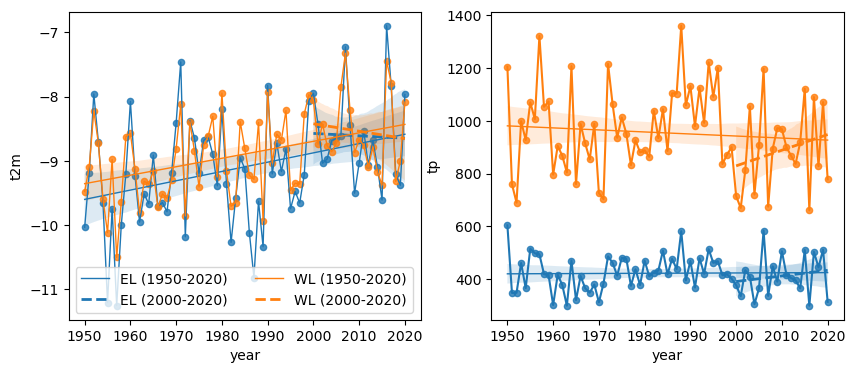

In [41]:
# To highlight the study period 2000-2020
f, ax = plt.subplots(1,2, figsize=(10,4))
ax=ax.flatten()

ax[0].plot(t2m_ano_el.year, t2m_ano_el, color='C0', label='EL (1950-2020)', linewidth=1)
sns.regplot(x=t2m_ano_el.year, y=t2m_ano_el, color='C0', ax=ax[0], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=t2m_ano_00_20_el.year, y=t2m_ano_00_20_el, color='C0', ax=ax[0], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False, label='EL (2000-2020)')

ax[0].plot(t2m_ano_wl.year, t2m_ano_wl, color='C1', label='WL (1950-2020)', linewidth=1)
sns.regplot(x=t2m_ano_wl.year, y=t2m_ano_wl, color='C1', ax=ax[0], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=t2m_ano_00_20_wl.year, y=t2m_ano_00_20_wl, color='C1', ax=ax[0], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False, label='WL (2000-2020)')

ax[1].plot(tp_ano_el.year, tp_ano_el, color='C0', label='EL (1950-2020)')
sns.regplot(x=tp_ano_el.year, y=tp_ano_el, color='C0', ax=ax[1], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=tp_ano_00_20_el.year, y=tp_ano_00_20_el, color='C0', ax=ax[1], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False)

ax[1].plot(tp_ano_wl.year, tp_ano_wl, color='C1', label='WL (1950-2020)')
sns.regplot(x=tp_ano_wl.year, y=tp_ano_wl, color='C1', ax=ax[1], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=tp_ano_00_20_wl.year, y=tp_ano_00_20_wl, color='C1', ax=ax[1], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False)


ax[0].legend(ncol=2)
#plt.savefig('temp.jpeg', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
t2m_ano.mean(), tp_ano.mean()

(<xarray.DataArray 't2m_ano' ()>
 array(0.1660305, dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray 'tp_ano' ()>
 array(-7.0573297, dtype=float32)
 Coordinates:
     spatial_ref  int64 0)

In [26]:
# Mean anomaly 2000-2020
t2m_ano_00_20.mean(), tp_ano_00_20.mean()

(<xarray.DataArray 't2m_ano' ()>
 array(0.46768108, dtype=float32)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray 'tp_ano' ()>
 array(-27.11909, dtype=float32)
 Coordinates:
     spatial_ref  int64 0)

In [ ]:
# Mean anomaly slope 2000-2020
print(np.polyfit(t2m_ano_00_20.year,t2m_ano_00_20,1)[0])
print(np.polyfit(tp_ano_00_20.year,tp_ano_00_20,1)[0])

## Final plots

In [ ]:
# Figure
fig = plt.figure()
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([72,82,30,38])
tp_trend.slope.plot(robust=True, ax=ax)
footprint.plot(ax=ax, edgecolor='k', facecolor='none', linestyle='--', legend=True)
him = him_regions.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='-', column=him_regions.himap_regi, 
                 legend=True, cmap='Set1_r', legend_kwds={'loc': 'lower left'});
leg = him.get_legend()
leg.get_frame().set_alpha(0.3)

# P-values
# https://medium.com/@wenzhao.li1989/hypothesis-testing-of-the-trend-calculated-from-linear-regression-significance-test-3317a47ef3d1
ax.contourf(tp_trend.longitude, tp_trend.latitude, tp_trend.p_value, 
            [np.min(tp_trend.p_value),0.05,np.max(tp_trend.p_value)], 
            zorder=1, hatches=['..', None], colors="none", transform=ccrs.PlateCarree(), alpha=0)

# Grids
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='gray', alpha=0.2, linestyle='-',
                 x_inline=False, y_inline=False)
gl.right_labels = False
gl.bottom_labels = False


ax.set_title('Annual Precipitation Trend for 1950-2021 (ERA5-Land)', size=12)
plt.show()

# Step-wise decadal/5-year plot

In [20]:
# t2m_annual_df = t2m_aoi_masked.mean(dim=['longitude','latitude'])
# t2m_annual_df = t2m_annual_df.to_dataframe()
# t2m_annual_df.to_csv('t2m_aoi_annual_df.csv')

# tp_annual_df = tp_aoi_masked.mean(dim=['longitude','latitude'])
# tp_annual_df = tp_annual_df.to_dataframe()
# tp_annual_df.to_csv('tp_aoi_annual_df.csv')

# WL
# t2m_annual_wl_df = t2m_wl_masked.mean(dim=['longitude','latitude'])
# t2m_annual_wl_df = t2m_annual_wl_df.to_dataframe()
# t2m_annual_wl_df.to_csv('t2m_annual_wl_df.csv')

# tp_annual_wl_df = tp_wl_masked.mean(dim=['longitude','latitude'])
# tp_annual_wl_df = tp_annual_wl_df.to_dataframe()
# tp_annual_wl_df.to_csv('tp_annual_wl_df.csv')

# EL
# t2m_annual_el_df = t2m_el_masked.mean(dim=['longitude','latitude'])
# t2m_annual_el_df = t2m_annual_el_df.to_dataframe()
# t2m_annual_el_df.to_csv('t2m_annual_el_df.csv')

# tp_annual_el_df = tp_el_masked.mean(dim=['longitude','latitude'])
# tp_annual_el_df = tp_annual_el_df.to_dataframe()
# tp_annual_el_df.to_csv('tp_annual_el_df.csv')

In [43]:
t2m_decadal_df = pd.read_csv('t2m_aoi_annual_df.csv')
tp_decadal_df = pd.read_csv('tp_aoi_annual_df.csv')

# WL
t2m_decadal_wl = pd.read_csv('t2m_annual_wl_df.csv')
tp_decadal_wl = pd.read_csv('tp_annual_wl_df.csv')

# EL
t2m_decadal_el = pd.read_csv('t2m_annual_el_df.csv')
tp_decadal_el = pd.read_csv('tp_annual_el_df.csv')

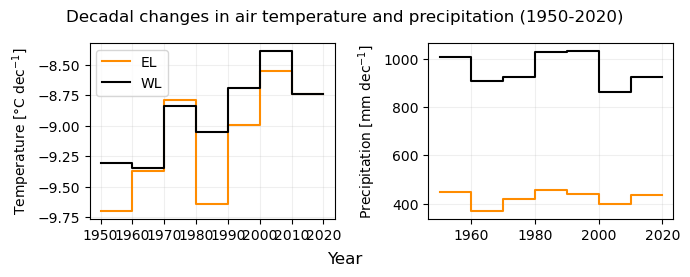

In [44]:
f, ax = plt.subplots(1,2, figsize=(7,2.6))
ax=ax.flatten()

ax[0].plot(t2m_decadal_el.year, t2m_decadal_el.decadal, c='darkorange', label='EL')
ax[0].plot(t2m_decadal_wl.year, t2m_decadal_wl.decadal, c='k', label='WL')

ax[1].plot(tp_decadal_el.year, tp_decadal_el.decadal, c='darkorange')
ax[1].plot(tp_decadal_wl.year, tp_decadal_wl.decadal, c='k')

ax[0].set_ylabel('Temperature [°C dec$^{-1}$]')
ax[1].set_ylabel('Precipitation [mm dec$^{-1}$]')
f.supxlabel('Year', y=0.08)
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

major_ticks = np.arange(1950, 2021, 10)
ax[0].set_xticks(major_ticks)

ax[0].legend()
plt.tight_layout()
f.suptitle('Decadal changes in air temperature and precipitation (1950-2020)', size=12, y=1.07)
#plt.savefig('Decadal_changes_t2m_tp.jpeg', bbox_inches='tight', dpi=300)
plt.show()

# Final Plot

<Figure size 640x480 with 0 Axes>

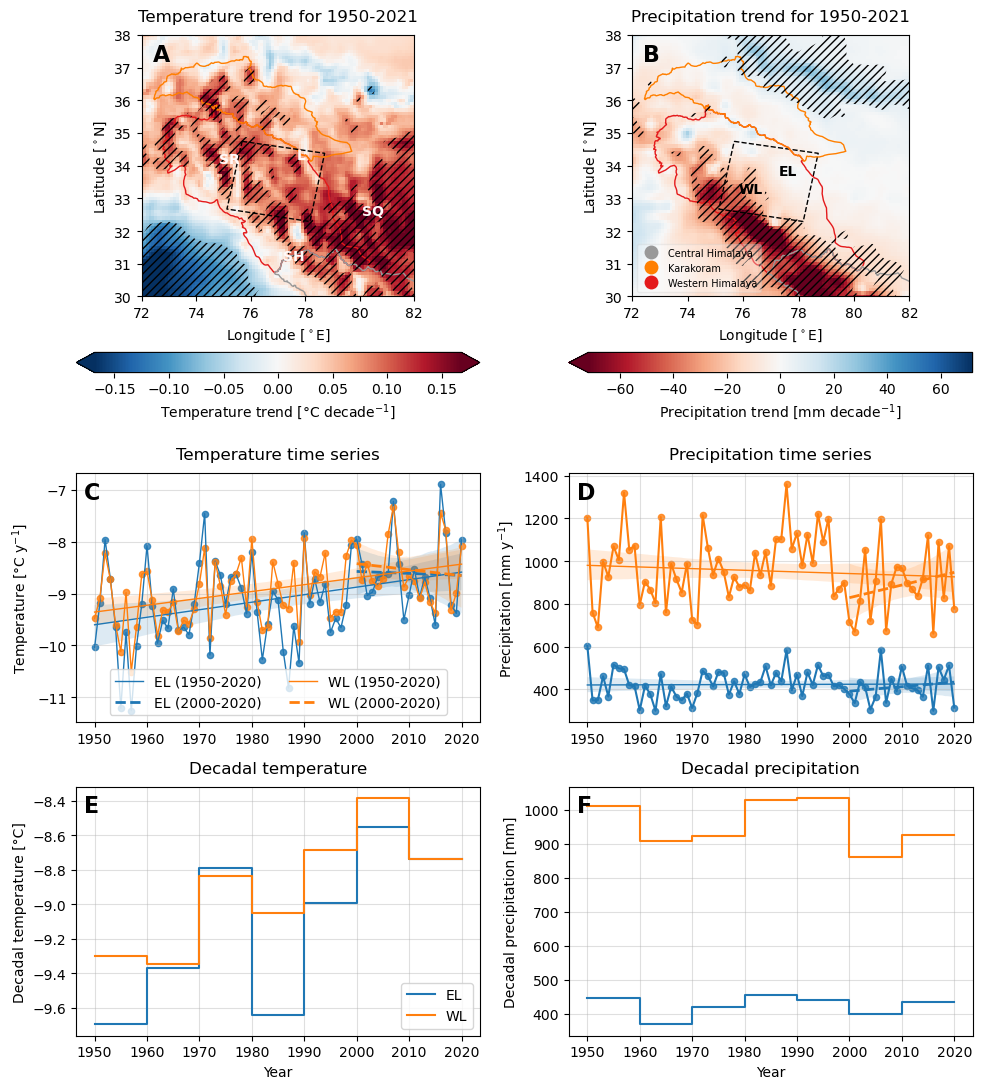

In [67]:
# Figure: MULTI-PANEL
f = plt.figure()    
f, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,11), gridspec_kw={'height_ratios': [3,2,2]})

# -- Plot 1
axes[0][0].text(0.04, 0.97, 'A', transform=axes[0][0].transAxes, fontsize=16, fontweight='bold', va='top')
t2m_trend.slope.plot(robust=True, ax=axes[0][0], cbar_kwargs={'label':'Temperature trend [°C decade$^{-1}$]',
                                                        'orientation': 'horizontal'})
him = him_regions.plot(ax=axes[0][0], facecolor='none', linestyle='-', column=him_regions.himap_regi, 
                 legend=False, cmap='Set1_r');
footprint.plot(ax=axes[0][0], edgecolor='k', facecolor='none', linestyle='--')
axes[0][0].set_xlim([72,82])
axes[0][0].set_ylim([30,38])

# P-values
axes[0][0].contourf(t2m_trend.longitude, t2m_trend.latitude, t2m_trend.p_value, 
            [np.min(t2m_trend.p_value),0.05,np.max(t2m_trend.p_value)], 
            zorder=1, hatches=['////', None], colors="none", alpha=0)

# -- Plot 2
axes[0][1].text(0.04, 0.97, 'B', transform=axes[0][1].transAxes, fontsize=16, fontweight='bold', va='top')
tp_trend.slope.plot(robust=True, ax=axes[0][1], cmap= 'RdBu', cbar_kwargs={'label':'Precipitation trend [mm decade$^{-1}$]',
                                                        'orientation': 'horizontal'})
footprint.plot(ax=axes[0][1], edgecolor='k', facecolor='none', linestyle='--')
him = him_regions.plot(ax=axes[0][1], facecolor='none', linestyle='-', column=him_regions.himap_regi, 
                 legend=True, cmap='Set1_r', legend_kwds={'loc': 'lower left', 'fontsize': 7});
leg = him.get_legend()
leg.get_frame().set_alpha(0.3)
axes[0][1].set_xlim([72,82])
axes[0][1].set_ylim([30,38])

# P-values
# https://medium.com/@wenzhao.li1989/hypothesis-testing-of-the-trend-calculated-from-linear-regression-significance-test-3317a47ef3d1
axes[0][1].contourf(tp_trend.longitude, tp_trend.latitude, tp_trend.p_value, 
            [np.min(tp_trend.p_value),0.05,np.max(tp_trend.p_value)], 
            zorder=1, hatches=['////', None], colors="none", alpha=0)

# -- Plot 3
axes[1][0].text(0.02, 0.97, 'C', transform=axes[1][0].transAxes, fontsize=16, fontweight='bold', va='top')
axes[1][0].plot(t2m_ano_el.year, t2m_ano_el, color='C0', label='EL (1950-2020)', linewidth=1)
sns.regplot(x=t2m_ano_el.year, y=t2m_ano_el, color='C0', ax=axes[1][0], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=t2m_ano_00_20_el.year, y=t2m_ano_00_20_el, color='C0', ax=axes[1][0], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False, label='EL (2000-2020)')

axes[1][0].plot(t2m_ano_wl.year, t2m_ano_wl, color='C1', label='WL (1950-2020)', linewidth=1)
sns.regplot(x=t2m_ano_wl.year, y=t2m_ano_wl, color='C1', ax=axes[1][0], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=t2m_ano_00_20_wl.year, y=t2m_ano_00_20_wl, color='C1', ax=axes[1][0], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False, label='WL (2000-2020)')

# axes[1][0].axhline(y = 0, color = 'grey', linestyle = '--')
# axes[1][0].plot(t2m_ano.year, t2m_ano, color='C0', label='1950-2020')
# sns.regplot(x=t2m_ano.year, y=t2m_ano, color='C0', ax=axes[1][0], truncate=True)
# axes[1][0].plot(t2m_ano_00_20.year, t2m_ano_00_20, color='C3', label='2000-2020')
# sns.regplot(x=t2m_ano_00_20.year, y=t2m_ano_00_20, color='C3', ax=axes[1][0], truncate=True)
axes[1][0].legend(loc='lower center', ncol=2)

# -- Plot 4
axes[1][1].text(0.02, 0.97, 'D', transform=axes[1][1].transAxes, fontsize=16, fontweight='bold', va='top')
axes[1][1].plot(tp_ano_el.year, tp_ano_el, color='C0', label='EL (1950-2020)')
sns.regplot(x=tp_ano_el.year, y=tp_ano_el, color='C0', ax=axes[1][1], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=tp_ano_00_20_el.year, y=tp_ano_00_20_el, color='C0', ax=axes[1][1], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False)

axes[1][1].plot(tp_ano_wl.year, tp_ano_wl, color='C1', label='WL (1950-2020)')
sns.regplot(x=tp_ano_wl.year, y=tp_ano_wl, color='C1', ax=axes[1][1], truncate=True, line_kws={'linewidth':1}, scatter_kws={'s':20})
sns.regplot(x=tp_ano_00_20_wl.year, y=tp_ano_00_20_wl, color='C1', ax=axes[1][1], truncate=True, line_kws={"ls":'--','linewidth':2}, scatter=False)

# axes[1][1].axhline(y = 0, color = 'grey', linestyle = '--')
# axes[1][1].axhline(y = 0, color = 'grey', linestyle = '--')
# axes[1][1].plot(tp_ano.year, tp_ano, color='C0', label='1950-2020')
# sns.regplot(x=tp_ano.year, y=tp_ano, color='C0', ax=axes[1][1], truncate=True)
# axes[1][1].plot(tp_ano_00_20.year, tp_ano_00_20, color='C3', label='2000-2020')
# sns.regplot(x=tp_ano_00_20.year, y=tp_ano_00_20, color='C3', ax=axes[1][1], truncate=True)


# -- Plot 5
axes[2][0].text(0.02, 0.97, 'E', transform=axes[2][0].transAxes, fontsize=16, fontweight='bold', va='top')
axes[2][0].plot(t2m_decadal_el.year, t2m_decadal_el.decadal, label='EL')
axes[2][0].plot(t2m_decadal_wl.year, t2m_decadal_wl.decadal, label='WL')
axes[2][0].legend(loc='lower right')

# -- Plot 5
axes[2][1].text(0.02, 0.97, 'F', transform=axes[2][1].transAxes, fontsize=16, fontweight='bold', va='top')
axes[2][1].plot(tp_decadal_el.year, tp_decadal_el.decadal)
axes[2][1].plot(tp_decadal_wl.year, tp_decadal_wl.decadal)

# Axis labels
axes[0][0].set_xlabel('Longitude [$^\circ$E]')
axes[0][0].set_ylabel('Latitude [$^\circ$N]')
axes[0][1].set_xlabel('Longitude [$^\circ$E]')
axes[0][1].set_ylabel('Latitude [$^\circ$N]')
axes[1][0].set_ylabel('Temperature [°C y$^{-1}$]')
axes[1][1].set_ylabel('Precipitation [mm y$^{-1}$]')
axes[2][0].set_ylabel('Decadal temperature [°C]')
axes[2][1].set_ylabel('Decadal precipitation [mm]')
axes[2][0].set_xlabel('Year')
axes[2][1].set_xlabel('Year')
axes[1][0].set_xlabel(None)
axes[1][1].set_xlabel(None)

# Titles
axes[0][0].set_title('Temperature trend for 1950-2021', size=12, pad=10)
axes[0][1].set_title('Precipitation trend for 1950-2021', size=12, pad=10)
axes[1][0].set_title('Temperature time series', size=12, pad=10)
axes[1][1].set_title('Precipitation time series', size=12, pad=10)
axes[2][0].set_title('Decadal temperature', size=12, pad=10)
axes[2][1].set_title('Decadal precipitation', size=12, pad=10)

# Ref period text
# axes[1][0].text(1965, 1.50, 'Reference period: 1980-1999', horizontalalignment='left', alpha=0.7, size=10)
# axes[1][1].text(1965, 130, 'Reference period: 1980-1999', horizontalalignment='left', alpha=0.7, size=10)

axes[1][0].grid(alpha=0.4)
axes[1][1].grid(alpha=0.4)
axes[2][0].grid(alpha=0.4)
axes[2][1].grid(alpha=0.4)

#axes[0][0].scatter(77.7, 34.2, marker='o', c='white', s=10)
axes[0][0].text(77.7, 34.2, 'L', c='snow', weight="bold")
axes[0][0].text(74.833, 34.083, 'SR', c='snow', weight="bold")
axes[0][0].text(77.167, 31.1, 'SH', c='snow', weight="bold")
axes[0][0].text(80.083, 32.5, 'SQ', c='snow', weight="bold")

axes[0][1].text(77.3, 33.7, 'EL', c='k', weight="bold")
axes[0][1].text(75.85, 33.15, 'WL', c='k', weight="bold")

# Save or show
plt.tight_layout()
plt.savefig('Figure_trends.jpeg', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

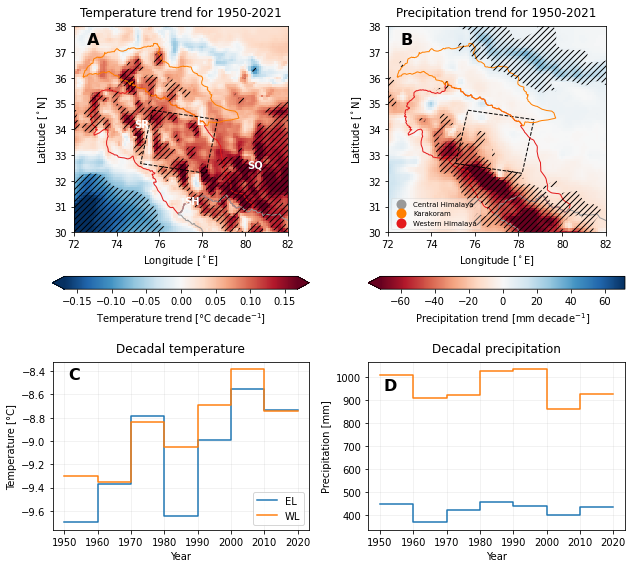

In [82]:
# Figure: MULTI-PANEL
f = plt.figure()    
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(9,8), gridspec_kw={'height_ratios': [3.5,2]})

# -- Plot 1
axes[0][0].text(0.06, 0.97, 'A', transform=axes[0][0].transAxes, fontsize=16, fontweight='bold', va='top')
t2m_trend.slope.plot(robust=True, ax=axes[0][0], cbar_kwargs={'label':'Temperature trend [°C decade$^{-1}$]',
                                                        'orientation': 'horizontal'})
him = him_regions.plot(ax=axes[0][0], facecolor='none', linestyle='-', column=him_regions.himap_regi, 
                 legend=False, cmap='Set1_r');
footprint.plot(ax=axes[0][0], edgecolor='k', facecolor='none', linestyle='--')
axes[0][0].set_xlim([72,82])
axes[0][0].set_ylim([30,38])

# P-values
axes[0][0].contourf(t2m_trend.longitude, t2m_trend.latitude, t2m_trend.p_value, 
            [np.min(t2m_trend.p_value),0.05,np.max(t2m_trend.p_value)], 
            zorder=1, hatches=['////', None], colors="none", alpha=0)

# -- Plot 2
axes[0][1].text(0.06, 0.97, 'B', transform=axes[0][1].transAxes, fontsize=16, fontweight='bold', va='top')
tp_trend.slope.plot(robust=True, ax=axes[0][1], cmap= 'RdBu', cbar_kwargs={'label':'Precipitation trend [mm decade$^{-1}$]',
                                                        'orientation': 'horizontal'})
footprint.plot(ax=axes[0][1], edgecolor='k', facecolor='none', linestyle='--')
him = him_regions.plot(ax=axes[0][1], facecolor='none', linestyle='-', column=him_regions.himap_regi, 
                 legend=True, cmap='Set1_r', legend_kwds={'loc': 'lower left', 'fontsize': 7});
leg = him.get_legend()
leg.get_frame().set_alpha(0.3)
axes[0][1].set_xlim([72,82])
axes[0][1].set_ylim([30,38])

# P-values
# https://medium.com/@wenzhao.li1989/hypothesis-testing-of-the-trend-calculated-from-linear-regression-significance-test-3317a47ef3d1
axes[0][1].contourf(tp_trend.longitude, tp_trend.latitude, tp_trend.p_value, 
            [np.min(tp_trend.p_value),0.05,np.max(tp_trend.p_value)], 
            zorder=1, hatches=['////', None], colors="none", alpha=0)

# -- Plot 5
axes[1][0].text(0.06, 0.97, 'C', transform=axes[1][0].transAxes, fontsize=16, fontweight='bold', va='top')
axes[1][0].plot(t2m_decadal_el.year, t2m_decadal_el.decadal, label='EL')
axes[1][0].plot(t2m_decadal_wl.year, t2m_decadal_wl.decadal, label='WL')

# -- Plot 5
axes[1][1].text(0.06, 0.90, 'D', transform=axes[1][1].transAxes, fontsize=16, fontweight='bold', va='top')
axes[1][1].plot(tp_decadal_el.year, tp_decadal_el.decadal)
axes[1][1].plot(tp_decadal_wl.year, tp_decadal_wl.decadal)

# Axis labels
axes[0][0].set_xlabel('Longitude [$^\circ$E]')
axes[0][0].set_ylabel('Latitude [$^\circ$N]')
axes[0][1].set_xlabel('Longitude [$^\circ$E]')
axes[0][1].set_ylabel('Latitude [$^\circ$N]')
axes[1][0].set_ylabel('Temperature [°C]')
axes[1][1].set_ylabel('Precipitation [mm]')
axes[1][0].set_xlabel('Year')
axes[1][1].set_xlabel('Year')


# Titles
axes[0][0].set_title('Temperature trend for 1950-2021', size=12, pad=10)
axes[0][1].set_title('Precipitation trend for 1950-2021', size=12, pad=10)
axes[1][0].set_title('Decadal temperature', size=12, pad=10)
axes[1][1].set_title('Decadal precipitation', size=12, pad=10)


axes[1][0].grid(alpha=0.2)
axes[1][1].grid(alpha=0.2)

#axes[0][0].scatter(77.7, 34.2, marker='o', c='white', s=10)
axes[0][0].text(77.7, 34.2, 'L', c='white', weight="bold")
axes[0][0].text(74.833, 34.083, 'SR', c='white', weight="bold")
axes[0][0].text(77.167, 31.1, 'SH', c='white', weight="bold")
axes[0][0].text(80.083, 32.5, 'SQ', c='white', weight="bold")

axes[1][0].legend(loc='lower right')
major_ticks = np.arange(1950, 2021, 10)
axes[1][0].set_xticks(major_ticks)
axes[1][1].set_xticks(major_ticks)

# Save or show
plt.tight_layout()
plt.savefig('Figure_trends.jpeg', bbox_inches='tight', dpi=300)
plt.show()

# --End--